# 对海洋数据进行hilbert EOF 分解

## 下载数据
*数据来源于欧洲哥白尼数据中心全球海洋再分析数据(表层盐度月平均) ,利用其提供的Python API快捷下载*    
***(注意：新用户需要注册)***

---
**维度**
  
- **time**：`2001-01~2020-12`
- **lon**：`30°E~140°E`
- **lat**：`20°S~31°N`
- **variables**:`uo, vo`
---
**链接**
- [https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/services]
  ![](./homework_pictures/2025-04-16-10-28-58.png)

In [ ]:
import copernicusmarine
for year in range(2001,2021):
    copernicusmarine.subset(
      username='你的用户名',
      password='你的密码',
      dataset_id="cmems_mod_glo_phy_my_0.083deg_P1M-m",
      variables=["so"],
      minimum_longitude=30,
      maximum_longitude=140,
      minimum_latitude=-20,
      maximum_latitude=31,
      start_datetime="{}-01-01T00:00:00".format(year),
      end_datetime="{}-12-01T00:00:00".format(year),
      minimum_depth=0.49402499198913574,
      maximum_depth=0.49402499198913574,
      force_download=True,
      output_filename=r'D:\glorys\glorys{}'.format(year),
        )
    print(' data in {}year has been downloaded...'.format(year))


## 导入数据

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpt
import matplotlib.colors as mcolors
from matplotlib import ticker  
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator
import pandas as pd 
import xarray as xr
import pandas as pd
import xeofs as xe
import cartopy.mpl.ticker
from cartopy import crs as ccrs
from scipy.io import loadmat
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
from scipy.ndimage import gaussian_filter
plt.rcParams['font.family'] = 'Times New Roman'
mpt.rcParams['axes.unicode_minus']=False
np.set_printoptions(suppress=True)
%matplotlib inline

### 将数据拼接成一个文件

In [ ]:
so_list = []
for year in range(2001, 2021):
    filename = r'D:\glorys\glorys{}.nc'.format(year)
    so = xr.open_dataset(filename)['so'].isel(depth=0)  ##我不止下载了表层，为了演示，我只用表层的数据
    so = so.sel(longitude=slice(40, 110), latitude=slice(-15, 5))  # 截取热带印度洋部分
    so_list.append(so)
    print(year, end=' ')
so = xr.concat(so_list, dim='time')


2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 

### 传播现象在整个研究区域的全时间段都存在，在2008.03~2009.10有比较明显。

In [ ]:
so.isel(time=slice(86, 110)).plot.contourf(x='longitude', col='time', col_wrap=4, cmap='RdBu_r', levels=20)

### 简单标准化后，进行hilbert EOF

In [15]:
so = (so - so.mean(dim='time')) / so.std(dim='time')
def apply_Heof(da):
    model = xe.single.HilbertEOF(n_modes=3, use_coslat=True, random_state=7, padding='exp')
    model.fit(da, dim='time')
    eofs = model.components()
    pcs = model.scores()
    vars = model.explained_variance_ratio() 
    eofs_amp = model.components_amplitude()
    eofs_phase = model.components_phase()
    pcs_amp = model.scores_amplitude()
    pcs_phase = model.scores_phase()
    return eofs, pcs, vars, eofs_amp, eofs_phase, pcs_amp, pcs_phase

eofs, pcs, vars, eofs_amp, eofs_phase, pcs_amp, pcs_phase = apply_Heof(so)


c:\Users\Admin\anaconda3\envs\xeofs\Lib\site-packages\scipy\sparse\linalg\_eigen\_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.00000044 0.00000036 0.00002177]
not reaching the requested tolerance 3.5762786865234375e-06.
Use iteration 21 instead with accuracy 
7.519360821052714e-06.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
c:\Users\Admin\anaconda3\envs\xeofs\Lib\site-packages\scipy\sparse\linalg\_eigen\_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.00000043 0.00000035 0.00002177]
not reaching the requested tolerance 3.5762786865234375e-06.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


### 空间模态的分布
可以看到捕捉到了异常的南北传播信号(模态1和部分模态2)和东西传播信号(部分模态2和模态3)

Text(0.5, 0.99, 'eofs_amp')

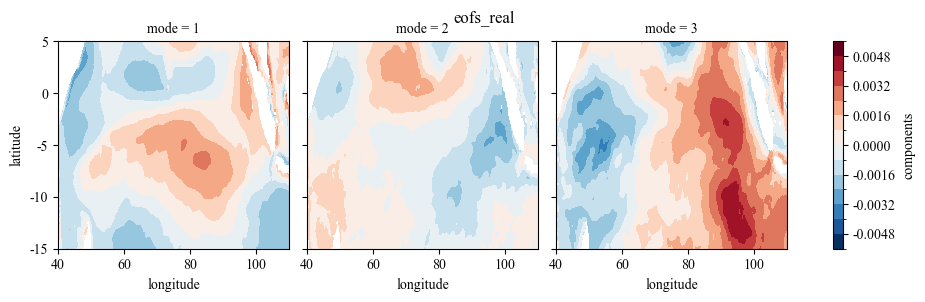

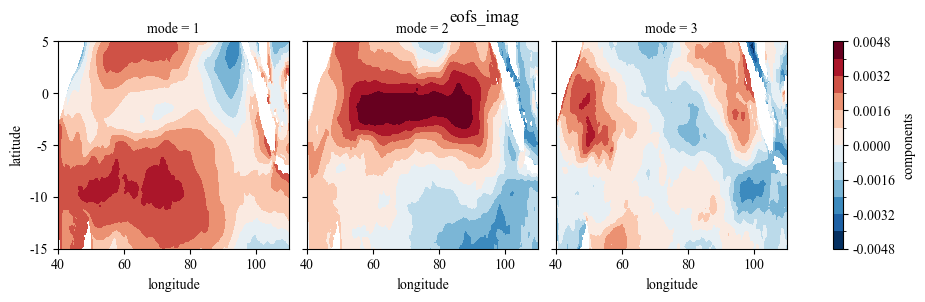

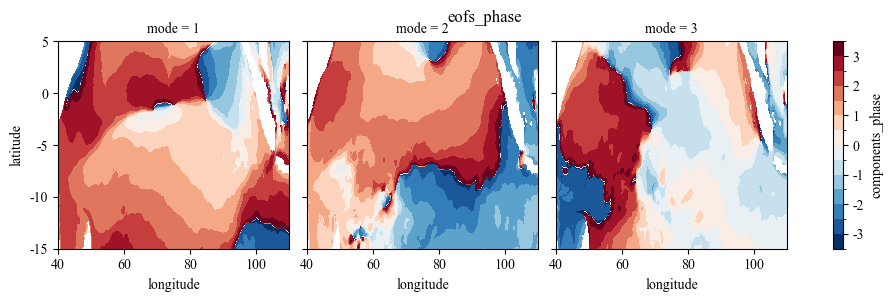

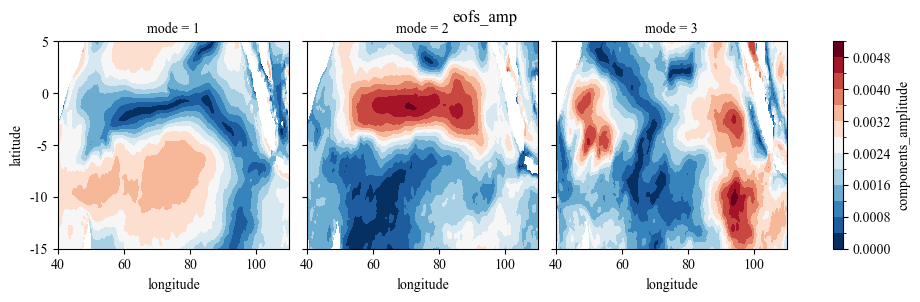

In [24]:
eofs.real.plot.contourf(col='mode', x='longitude', cmap='RdBu_r', levels=15)
plt.suptitle('eofs_real', y=0.99)
eofs.imag.plot.contourf(col='mode', x='longitude', cmap='RdBu_r', levels=15)
plt.suptitle('eofs_imag', y=0.99)
eofs_phase.plot.contourf(col='mode', x='longitude', cmap='RdBu_r', levels=15)
plt.suptitle('eofs_phase', y=0.99)
eofs_amp.plot.contourf(col='mode', x='longitude', cmap='RdBu_r', levels=15)
plt.suptitle('eofs_amp', y=0.99)

### 时间序列

Text(0.5, 0.99, 'pcs_amp')

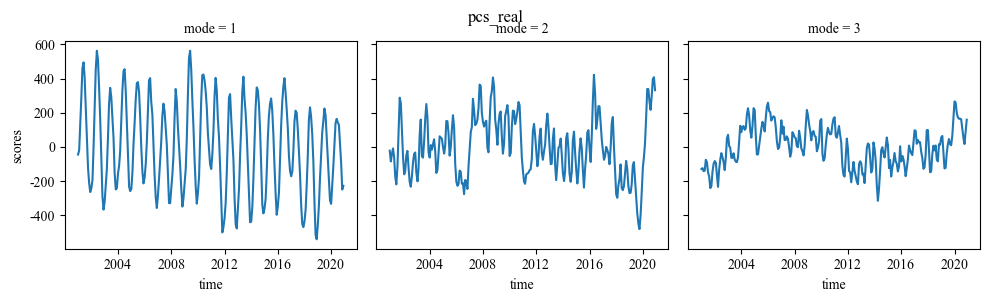

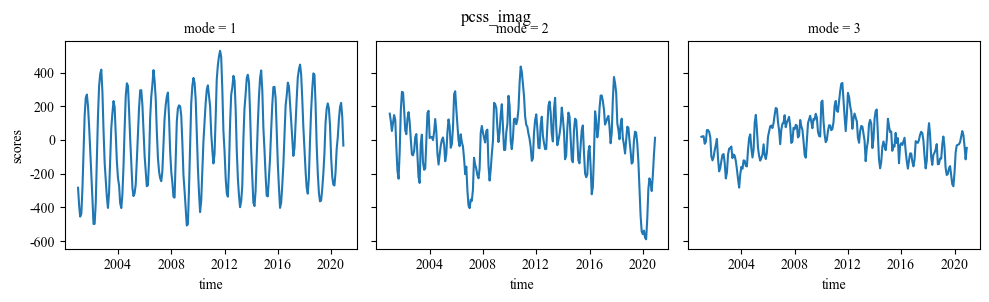

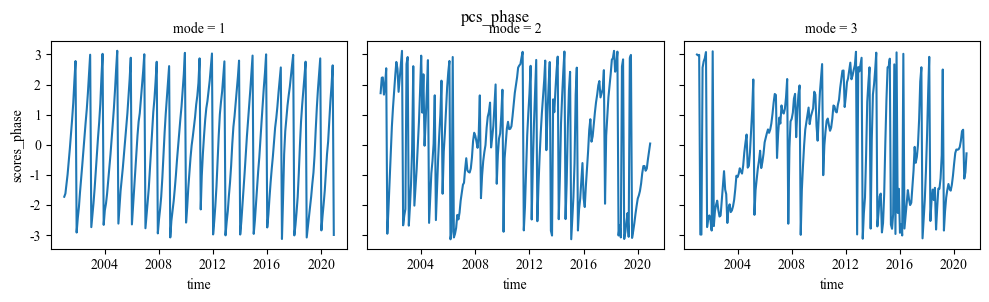

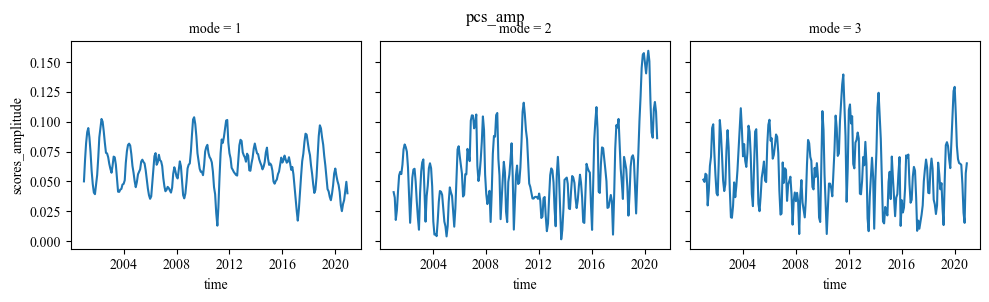

In [17]:
pcs.real.plot(col='mode', x='time')
plt.suptitle('pcs_real', y=0.99)
pcs.imag.plot(col='mode', x='time')
plt.suptitle('pcss_imag', y=0.99)
pcs_phase.plot(col='mode', x='time')
plt.suptitle('pcs_phase', y=0.99)
pcs_amp.plot(col='mode', x='time')
plt.suptitle('pcs_amp', y=0.99)